<a href="https://colab.research.google.com/github/mayssajeb/Reconnaissance-Signature/blob/master/Verif_Signature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Vérification Signature Manuscrite avec le deep Learning (CNN)**

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Stage_Wevioo_VérififcationSignature/Stage_Wevioo/BHSig260 - Copie/Hindi"

001  014  027  040  053  066  107  120	134  147  160
002  015  028  041  054  067  108  121	135  148  Hindi_pairs.txt
003  016  029  042  055  068  109  122	136  149  list.forgery
004  017  030  043  056  069  110  123	137  150  list.genuine
005  018  031  044  057  070  111  124	138  151  TestVerif.ipynb
006  019  032  045  058  071  112  125	139  152
007  020  033  046  059  098  113  127	140  153
008  021  034  047  060  099  114  128	141  154
009  022  035  048  061  100  115  129	142  155
010  023  036  049  062  103  116  130	143  156
011  024  037  050  063  104  117  131	144  157
012  025  038  051  064  105  118  132	145  158
013  026  039  052  065  106  119  133	146  159


In [0]:
import torch
import numpy as np
from torchvision import transforms, models, datasets

In [0]:
#Comment 0: define transformation that you wish to apply on image
data_transforms = transforms.Compose([
                    transforms.CenterCrop(224),
                    transforms.ToTensor()])

In [0]:
# Comment 1 : Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(root= "/content/drive/My Drive/Stage_Wevioo_VérififcationSignature/Stage_Wevioo/BHSig260 - Copie/Hindi", transform=data_transforms)

In [0]:
#Comment 2: Using the image datasets and the trainforms, define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=32, shuffle=True, num_workers=2)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image


dataiter = iter(dataloaders)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

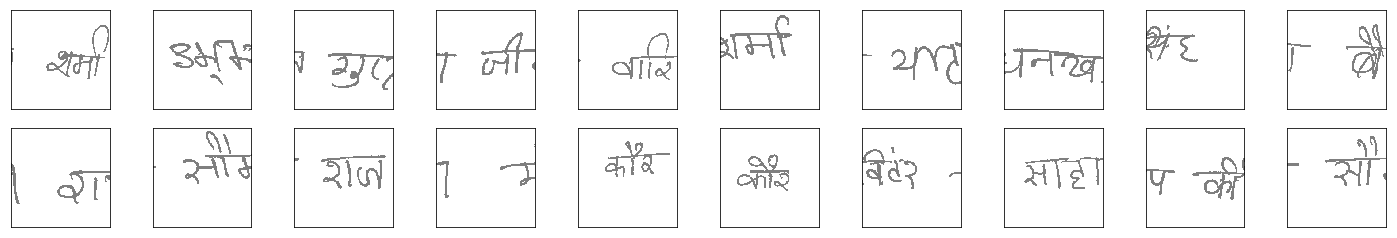

In [0]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [0]:
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
#Data pre-processing
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [93]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
    orig_groups, forg_groups = [], []
#for directory in dir_list:
    forg_groups.append(dataloaders[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(dataloaders[30:]) # Next 24 signatures are genuine

TypeError: ignored

In [0]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        #initialize vector for the targets
        targets=np.zeros((batch_size,))
        
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
             #a generator for batches
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [0]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [0]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [0]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    # function create the model architecture
    
    # Convolutional Neural Network
   
    # instantiate model (le modéle (seq)pile linéaire de couche)
    #The model type that we will be using is Sequential. Sequential is the easiest way to build a model in Keras
    #It allows you to build a model layer by layer.
    seq = Sequential()
    
    # 1ére couche
    #strides =le pas de convolution
    #activation RELU : le type de correction est RELU
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        init='glorot_uniform', dim_ordering='tf')) 
    #Normalisation 
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    # Max Pooling" permet de réduire l'image en conservant les valeurs les plus grandes des pixels
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))
    
    
     # 2éme couche
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
     # 3éme couche
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
     # 4éme couche
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, init='glorot_uniform', dim_ordering='tf'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    #dropout : méthode de régularisation permet de réoudre le sur-apprentissage 
    seq.add(Dropout(0.3))# added extra
    #Flatten est la fonction qui convertit le resultat aprés le pooling en une colonne unique transmise à 
    #la couche entièrement connectée. 
    seq.add(Flatten(name='flatten'))
    # Dense ajoute la couche entièrement connectée au réseau de neurones
    #Le premier paramètre est output_dim=1024, qui correspond au nombre de nœuds dans la couche masquée.
    #on choisit la fonction d’activation sigmoïde(relu) car nous attendons un résultat binaire. 
    #Si nous nous attendions à plus de deux résultats, nous utiliserions la fonction softmax.
    seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform')) # softmax changed to relu
    
    return seq

In [0]:
input_shape=(img_h, img_w, 1) # le shape d'entré est de taille img_h= 155, img_w = 220

In [85]:
# network definition
base_network = create_base_network_signet(input_shape)

#Define the tensors for the two input images
input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)

W0621 16:39:25.751832 139622895146880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, kernel_size=(11, 11), activation="relu", name="conv1_1", strides=4, input_shape=(155, 220,..., data_format="channels_last", kernel_initializer="glorot_uniform")`
  app.launch_new_instance()
W0621 16:39:25.804825 139622895146880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0621 16:39:25.815427 139622895146880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecate

In [86]:
batch_sz = 128
num_train_samples = 276*30 + 300*30
num_val_samples = num_test_samples = 276*10 + 300*10
num_train_samples, num_val_samples, num_test_samples

(17280, 5760, 5760)

In [87]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
#le taux d'apprentissage a été maintenu faible car il a été constaté qu'avec un taux d'apprentissage élevé, le modèle prenait beaucoup de temps à converger.
#Cependant, ces paramètres peuvent être optimisés pour améliorer les paramètres actuels.
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

W0621 16:39:53.772888 139622895146880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/signet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [91]:
# cela permet delancer l’apprentissage puis la validation 
results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

NameError: ignored